## Demonstrating functions for Reynolds scales project

TO-DO:
- Read Chuychai in more detail, possibly including the cited paper/s
- Bring in additional values, including $d_i$, to dataframe (related to density, NRL Formulary)
- Check with Tulasi
- Put into .py script

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm

while ".toplevel" not in os.listdir():
    os.chdir("..")

### Setting up dataset

In [2]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_20220325")

In [3]:
large_wind_df_hr.head()

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2022-03-25 00:00:00.000,4.159470,0.01092,0.446127,0.00531
2022-03-25 00:00:00.100,4.166633,0.01092,0.436836,0.00531
2022-03-25 00:00:00.200,4.157491,0.01092,0.402740,0.00531
2022-03-25 00:00:00.300,4.178423,0.01092,0.410756,0.00531
2022-03-25 00:00:00.400,4.159176,0.01092,0.378947,0.00531


In [4]:
# Working with a single 6-hour interval
wind_df_hr = large_wind_df_hr["2022-03-25 12:00":"2022-03-25 18:00"]
wind_df_hr.shape

(216600, 4)

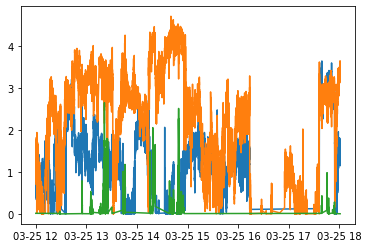

In [5]:
plt.plot(wind_df_hr[["BGSE_0", "BGSE_1", "BGSE_2"]])

In [6]:
# This dataframe is already at the high resolution (0.1s cadence). Setting aside a low resolution (cadence) version.
wind_df_lr = wind_df_hr.resample('5S').mean()
wind_df_lr.shape

(4332, 4)

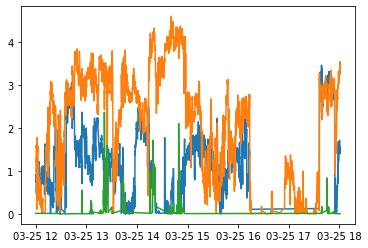

In [7]:
plt.plot(wind_df_lr[["BGSE_0", "BGSE_1", "BGSE_2"]])

### ACF function

Based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. Automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows:

$$R(\tau)=\frac{1}{3}\times(R_x(\tau)+R_y(\tau)+R_z(\tau))$$

*Should `tsa.acf()` be set to `fft=False`? Default is True. Check for differences in speed.*

In [8]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """
    if np_array.shape[0] == 3:
        acf = \
        sm.tsa.acf(np_array[0], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[1], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[2], fft=False, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=False, nlags=nlags)

    else:
        raise ValueError("Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt   

    # Optional plotting
    if show == True:

        fig, ax1 = plt.subplots()

        ax1.plot(time_lags, acf)
        ax2 = ax1.twiny()
        ax2.plot(np.arange(0, nlags+1), acf)

        ax1.set_xlabel('Lag (s)')
        ax2.set_xlabel('Lag ($\\tau$)')
        ax1.set_ylabel('Autocorrelation')
        plt.show()

    return time_lags, acf

Scalar version

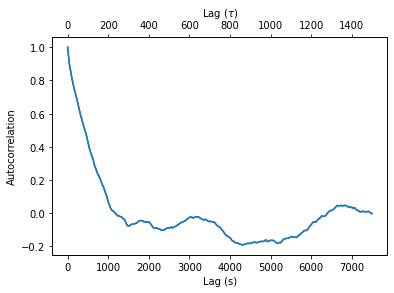

In [30]:
time_lags_lr, r_scalar_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0]), nlags=1500, dt = 5, show = True)

Vector version (same function, automatically detects). The following low-res ACF will be used for calculating the outer scale

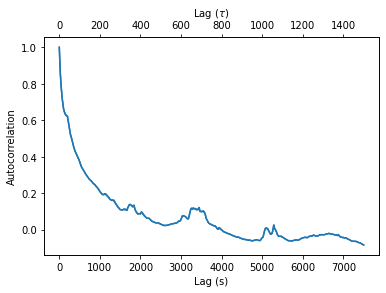

In [31]:
time_lags_lr, r_vec_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), nlags=1500, dt = 5, show = True)

The following high-res ACF will be used for calculating the Taylor scale. *This takes about 2.5 minutes to run*.

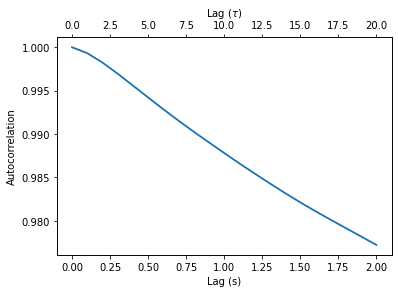

In [29]:
time_lags_hr, r_vec_hr = compute_nd_acf(np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), nlags=20, dt = 0.1, show = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Adapting Kevin's function for computing outer scale using exponential fit: from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$

"The extent of the autocorrelation to fit on was determined to be 1000 seconds worth of lag, through some trial and error and inspection of plotted results" (de Lange, 2021). Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

In [14]:
from utils import exp_fit

def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]

    # Optional plotting
    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation")
        plt.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('Lag (s)')
        #ax2.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()
    
    return lambda_c


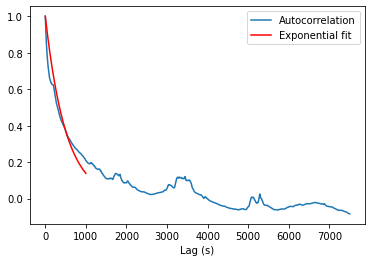

506.11751600139814

In [15]:
compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = 1000, show = True)

Using Kevin's function for computing outer scale using $1/e$ trick:

If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.

Kevin referred to the value calculated from this method as `estimate` and `Correlation_timescale_est`.

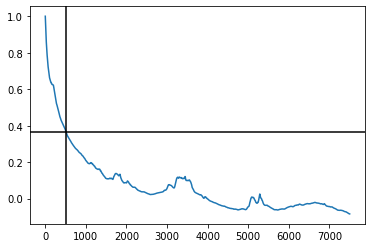

509.343

In [16]:
# import importlib
# import utils
# importlib.reload(utils)
# lambda_outer_exp_trick = utils.estimate_correlation_scale(time_lags_lr, r_vec_lr, show = True)

from utils import estimate_correlation_scale as compute_outer_scale_exp_trick
compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, show = True)

Creating function for computing outer scale as integral of the (longitudinal) ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970).

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [17]:
def compute_outer_scale_integral(time_lags, acf):
    # Compute the area using the composite trapezoidal rule.
    area = np.trapz(y = acf, x = time_lags)
    print("Area (trapz) =", area)

    # Compute the area using the composite Simpson's rule.
    area = scipy.integrate.simps(y = acf, x = time_lags)
    print("Area (simps) =", area)

    return area

In [18]:
compute_outer_scale_integral(time_lags_lr, r_vec_lr)

Area (trapz) = 533.5098954291816
Area (simps) = 533.503396895737


533.503396895737

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = curvature of ACF at the origin. 

Can calculate using second derivative at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This codes is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [19]:
from utils import para_fit

def compute_taylor_scale(time_lags, acf, tau_fit, show=False):
    """Compute the Taylor microscale
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_fit: number of lags to fit the parabola over
    """

    # If using seconds_fit as the fitting argument instead:

    # dt = time_lags[1]-time_lags[0]
    # tau_fit = int(seconds_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:tau_fit],
        acf[:tau_fit],
        p0=10)
    lambda_t = (-1*t_opt[0])**-.5

    # Optional plotting
    if show == True:
        ax = plt.gca()
        ax.set_ylim(0, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation", lw=2)
        plt.plot(
            np.array(range(int(1.2*lambda_t))),
            para_fit(np.array(range(int(1.2*lambda_t))), *t_opt),
            '-y',
            label = "Parabolic fit")
        #plt.axhline(0, color = 'black')
        ax.vlines(0, ymin = 0.95, ymax = 1.05, color = 'green')
        ax.vlines(tau_fit*(time_lags[1]-time_lags[0]), ymin = 0.92, ymax = 1.02, color = 'green')
        ax.set_xlabel('Lag (s)')
        #ax.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()

    return lambda_t


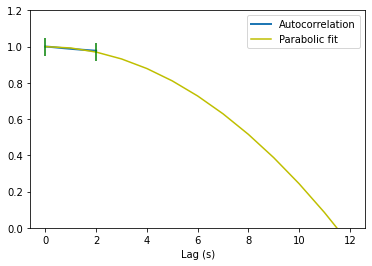

11.49777262199626

In [20]:
compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=20, show = True)

#### Chuychai (Richardson) extrapolation method

Calculate Taylor scale from parabolic fit for a range of values of `tau_fit`. Plot these values as a function of `tau_fit`, then draw a straight line through the points back to `tau_fit`=0. For the ACE data, Chuychai et al. used the range $4<\tau_{fit}<25$

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{fit}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain)

In [21]:
def compute_taylor_chuychai(time_lags, acf, tau_min, tau_max, show=False):
    """Compute a refined estimate of the Taylor microscale using a linear extrapolation method from Chuychai et al. (2014).
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_min: Minimum value for the upper lag to fit the parabola over. This should not be too small, because the data has finite time resolution and there may be limited data available at the shortest time lags. (You will see divergent behaviour if this happens.)
    - tau_max: Maximum value for the upper lag to fit the parabola over
    """

    tau_fit = np.arange(tau_min, tau_max+1)
    tau_ts = np.array([])

    for i in tau_fit:
        lambda_t = compute_taylor_scale(time_lags, acf, tau_fit=i, show=False)
        tau_ts = np.append(tau_ts, lambda_t)

    # Performing linear extrapolation back to tau_fit = 0
    z = np.polyfit(x=tau_fit, y=tau_ts, deg=1)
    f = np.poly1d(z)

    other_x = np.arange(0, tau_min+1)
    other_y = f(other_x)

    # Optional plotting
    if show == True:
        plt.plot(tau_fit, tau_ts, color="blue", label = "Range over which $\\tau_{TS}$ was calculated")
        plt.plot(other_x, other_y, color="cyan", label = "Linear extrapolation to $\\tau_{fit}$=0", ls = '--')
        plt.xlim(0, 30)
        plt.xlabel("$\\tau_{fit}$")
        plt.ylabel("$\\tau_{TS}$")
        plt.legend()
        plt.show()

    return other_y[0]


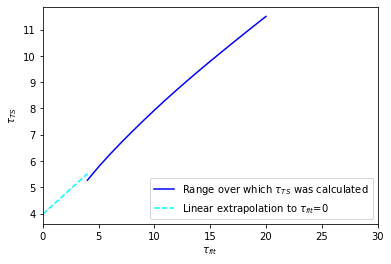

3.9868337518645727

In [22]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=4, tau_max=20, show = True)

Why can we not just calculate the $\tau_{TS}$ right up to the origin? Let's toggle `tau_min` right down:

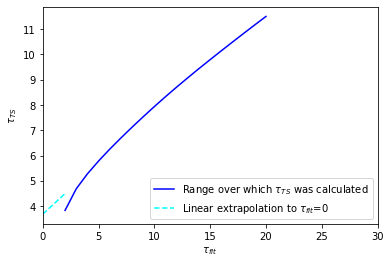

3.6834853767143327

In [23]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=2, tau_max=20, show = True)